In [1]:
import numpy as np
# import my_torchbox as tb
import parseBrats as pB
import matplotlib.pyplot as plt
import skimage
from scipy.ndimage import binary_dilation
# TDA
import persim
import cripser

%load_ext autoreload
%autoreload 2
from misc import *
import segmentation_TDA as sTDA
import  stickEdges as sE

# Open images.

BratS lint is 10 long
>> BraTS2021_01245
BraTS name : BraTS2021_01245


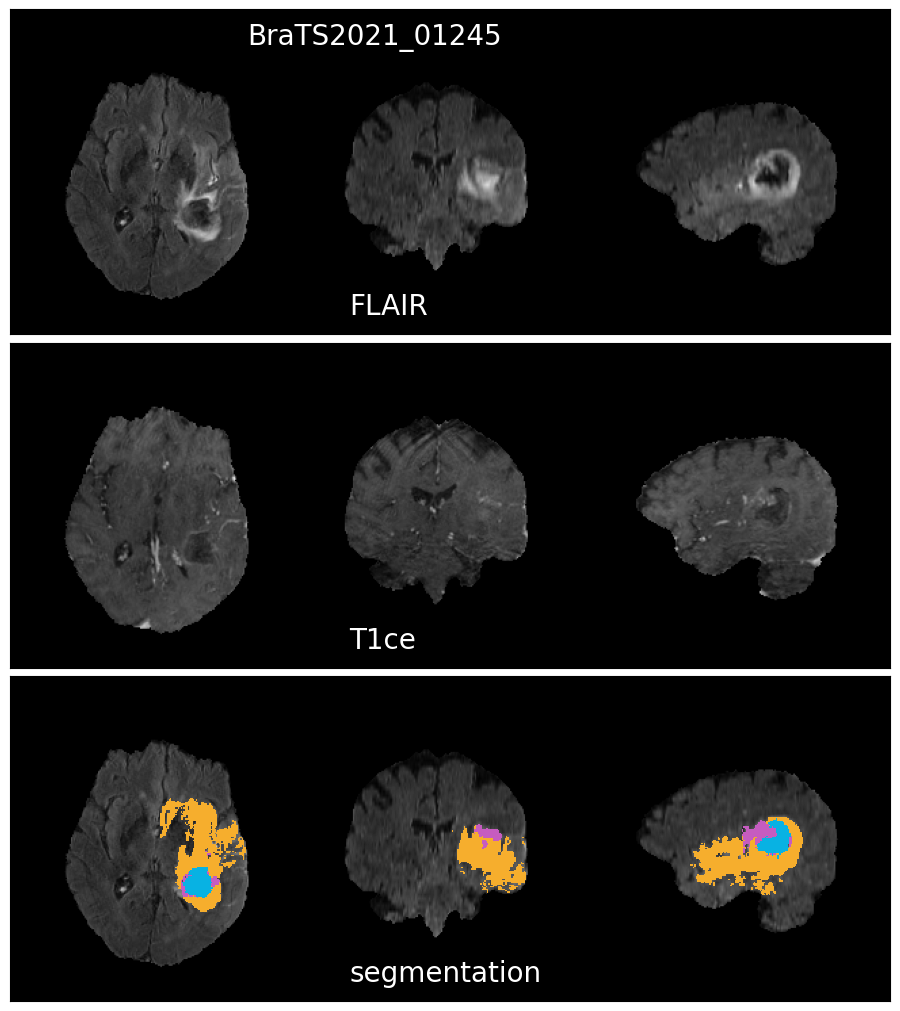

In [2]:
# You can select one or more file by putting them into brats_list
# Or set to None to choose randomly from the whole data set.
# brats_list = None

brats_list = ["BraTS2021_01360","BraTS2021_01053","BraTS2021_01143","BraTS2021_01121","BraTS2021_00318",'BraTS2021_01296','BraTS2021_00636','BraTS2021_00557','BraTS2021_01245','BraTS2021_00113']

# brats_list = ['BraTS2021_00331','BraTS2021_00021','BraTS2021_00597','BraTS2021_00098','BraTS2021_00149','BraTS2021_00043','BraTS2021_00412','BraTS2021_00155','BraTS2021_00321','BraTS2021_00366','BraTS2021_00012']
pb = pB.Parse_brats(brats_list=brats_list,
                    brats_folder='2021',
                    modality='flair',
                    get_template=False)
print(f"BratS lint is {len(pb.brats_list)} long")

i = 8
# i = np.random.randint(len(pb.brats_list))
brats_name = pb.brats_list[i]
print('>>',brats_name)

img_flair,seg_true, = pb(i,to_torch=False,modality='flair',normalize=True)
img_t1ce,_, = pb(i,to_torch=False,modality='t1ce')
img_t2,_, = pb(i,to_torch=False,modality='t2')
img_t1,_, = pb(i,to_torch=False,modality='t1')

seg_union_true = seg_true.copy()
seg_union_true[seg_true > 0] =1
print(f"BraTS name : {pb.brats_list[i]}")
sigma= 1
img_flair_b = scipynd.gaussian_filter(img_flair, sigma=sigma)
pos= sTDA.argmax_image(img_flair_b)

fig,ax = plt.subplots(3,1,figsize=(12,10),constrained_layout=True)
ax[0].imshow(make_3d_flat(img_flair,pos ),cmap='gray',vmax=1)
ax[0].text(175,25,pb.brats_list[i],c='white',fontsize=20)
ax[0].text(250,225,'FLAIR',c='white',fontsize=20)
ax[2].imshow(make_3d_flat(img_flair,pos ),cmap='gray',vmax=1)
ax[2].text(250,225,'segmentation',c='white',fontsize=20)
ax[2].imshow(make_3d_flat(seg_true,pos),**DLT_KW_SEG)
ax[1].imshow(make_3d_flat(img_t1ce,pos ),cmap='gray',vmax=1)
ax[1].text(250,225,'T1ce',c='white',fontsize=20)
set_ticks_off(ax)

In [9]:
@time_it
def susan_noise_reduction(image, t, radius):
    # Create a circular mask
    x, y, z = np.ogrid[-radius:radius+1, -radius:radius+1, -radius:radius+1]
    mask = np.sqrt(x**2 + y**2 + z**2) <= radius

    # Initialize the denoised image
    denoised_image = np.zeros_like(image)

    # Calculate the mean intensity of each segment
    for i in range(radius, image.shape[0] - radius):
        for j in range(radius, image.shape[1] - radius):
            for k in range(radius, image.shape[2] - radius):
                segment = image[i-radius:i+radius+1, j-radius:j+radius+1, k-radius:k+radius+1]
                if np.sum(segment) == 0:
                    denoised_image[i, j, k] = 0
                    continue
                mean_intensity = np.mean(segment)

                # Count the number of pixels within the circular mask that have an intensity difference less than the threshold t
                num_pixels = np.sum(mask * ((segment - mean_intensity) ** 2 < t**2))

                # If the number of pixels is greater than a certain threshold, replace the center pixel with the mean intensity of the segment
                if num_pixels > 27:
                    denoised_image[i, j, k] = mean_intensity
                else:
                    denoised_image[i, j, k] = image[i, j, k]

    return denoised_image

flair_denoised_susan = susan_noise_reduction(img_flair, t=0.1, radius=2)
t1ce_denoised_susan = susan_noise_reduction(img_t1ce, t=0.1, radius=2)



Computation of susan_noise_reduction done in  0:02:29s and 0.016cents  s

Computation of susan_noise_reduction done in  0:02:29s and 0.383cents  s


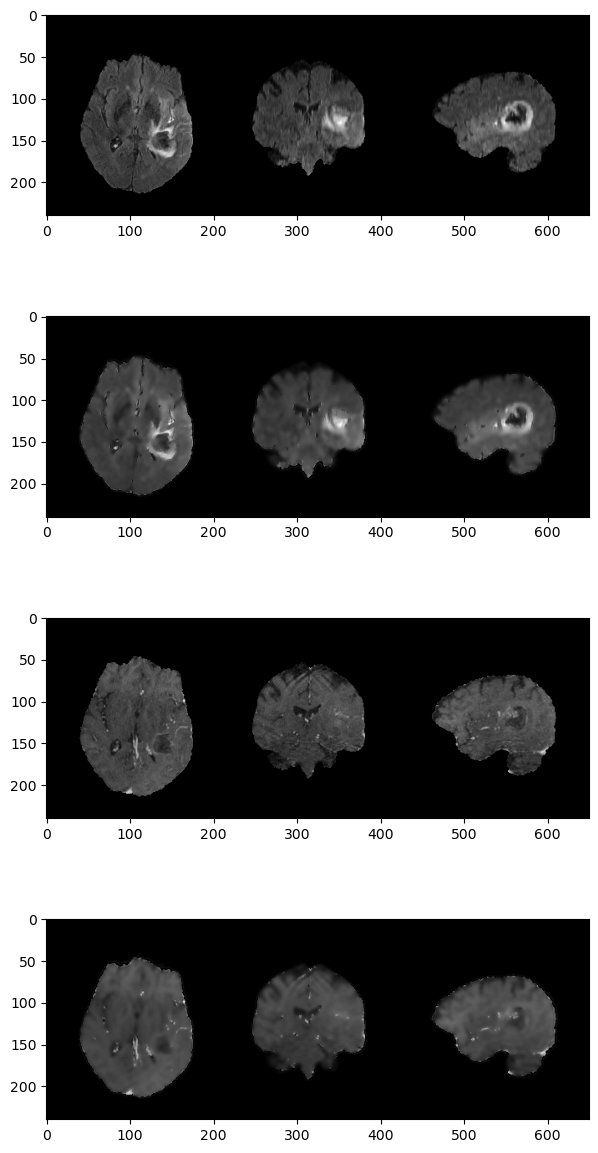

In [8]:
%matplotlib inline
fig,ax = plt.subplots(4,1,figsize = (7,15))
ax[0].imshow(make_3d_flat(img_flair,pos), cmap='gray')
ax[1].imshow(make_3d_flat(flair_denoised_susan,pos), cmap='gray')
ax[2].imshow(make_3d_flat(img_t1ce,pos), cmap='gray')
ax[3].imshow(make_3d_flat(t1ce_denoised_susan,pos), cmap='gray')
plt.show()


In [ ]:


NT =100
filtration = np.zeros((NT,)+img_flair.shape)
t_list = np.linspace(0,1,NT)
sum_filt = np.zeros_like(t_list)
for i,t in enumerate(t_list):
    print(i,t)
    filtration[i] = img_flair > t
    sum_filt[i] = filtration[i].sum()

cmap_filt = ListedColormap(
    [[0,0,0,0],
    '#F29E4C' # Blue (Munsell)
     ])
path = "/home/turtlefox/Documents/Doctorat/Presentation/9_Mistic/filtration/"

max_val = sum_filt.max()
for i in range(NT):
    # print(filtration[NT- i-1].sum())
    fig,ax = plt.subplots(2,1,figsize=(11,8),constrained_layout=True)
    ax[0].imshow( make_3d_flat( img_flair, pos),cmap='gray')
    ax[0].imshow( make_3d_flat( filtration[NT -i-1], pos),cmap=cmap_filt,interpolation='nearest')
    ax[0].set_title(f"t= {t_list[NT -i-1]:.2f}")
    set_ticks_off(ax[0])

    ax[1].plot(t_list,sum_filt,'go-')
    # vertical line that parse at the value of t
    ax[1].axvline(t_list[NT -i-1],c='r')
    ax[1].set_ylim(0,max_val)
    ax[1].set_xlabel('t')
    fig.savefig(path+ f"filtration_ax_{i:02d}.png")

# make a video in .mp4 from the above plots
# !ffmpeg -framerate 1 -i {path}filtration_ax_%02d.png -c:v libx264 -r 30 -pix_fmt yuv420p {path}filtration.mp4



# Step 1 : Union segmentation:

In this step, our goal is to select the largest hyper-intense region present in the FLAIR image that we note $X$. To achieve this, we analyse the number of voxels in the filtration process over time, starting from $t=1$ and moving to $t=0$. While the number of voxels increases steadily, we anticipate a sharp increase in the number of voxels when the voxels corresponding to the white and grey matter are included. Therefore, we select the value of $t$ just before this sharp increase. To do this, we examine the derivative of the number of voxels with respect to $t$, and choose the first derivative value that exceeds a predefined threshold. This process is similar to a binarisation algorithm, such as Otsu's method. Once we have selected the optimal value of $t$, we then identify the largest connected component, which corresponds to the region with the most voxels.


suggest_t : Compute curve... 

Computation of suggest_t done in  0:00:00s and 0.309cents  s
There are 85489 labels


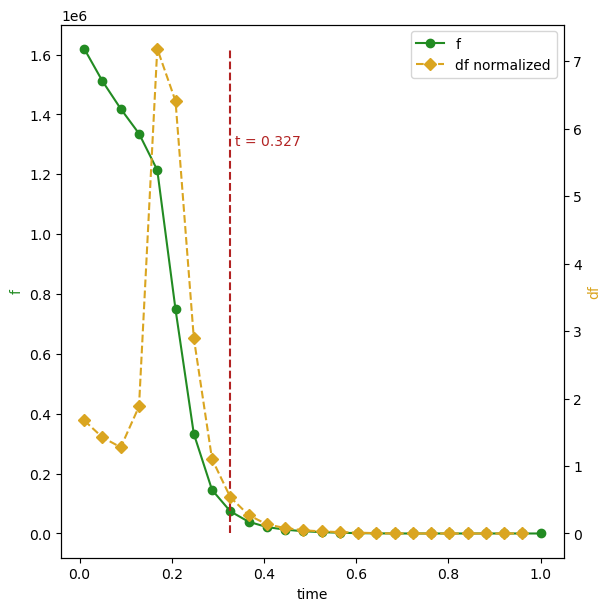

In [4]:
# img_flair_b = flair_denoised_susan
t,_,_,_ = sTDA.suggest_t(img_flair_b, dt_threshold=1, verbose=True, plot=True)
# t,_,_,_ = sTDA.suggest_t(flair_denoised_susan, dt_threshold=1, verbose=True, plot=True)


# Extract
seg_union = sTDA.get_largest_CC(img_flair, t, verbose=True)
# seg_union = sTDA.get_largest_CC(flair_denoised_susan, t, verbose=True)

## Stick to edges

Check edges match before edges refinement.

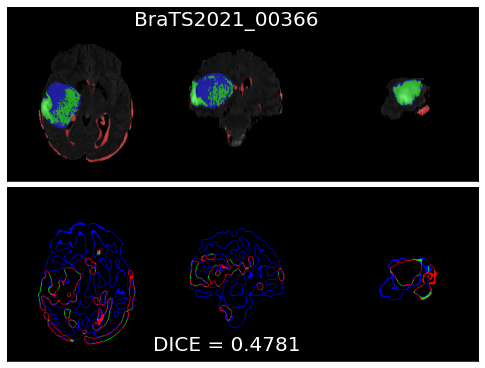

In [14]:
edgeDice = sE.EdgesMatch_Dice(img_flair)


fig, ax = plt.subplots(2,1,
                            figsize = (10,5),
                            constrained_layout=True)

edgeDice(seg_union)
img_flat = make_3d_flat(img_flair,pos)
ax[0].imshow(img_flat,alpha = 1, **DLT_KW_IMAGE)
ax[0].imshow(imCmp(
    make_3d_flat(seg_union,pos),
    make_3d_flat(seg_union_true,pos),
    method='seg'
),
    alpha = .5
)
if not brats_name is None:
    ax[0].text(175,25,brats_name,c='white',fontsize=20)
ax[1].text(200,225,f"DICE = {DICE(seg_union,seg_union_true):.4f}",c='white',fontsize=20)
set_ticks_off(ax[1])
ax[1].imshow(
    imCmp(
    make_3d_flat(edgeDice.seg_edges,pos),
    make_3d_flat(edgeDice.img_edges,pos),
    method='seg'
    )
)
set_ticks_off(ax)



size difference : 0.09173821307378922 10.900582935877054



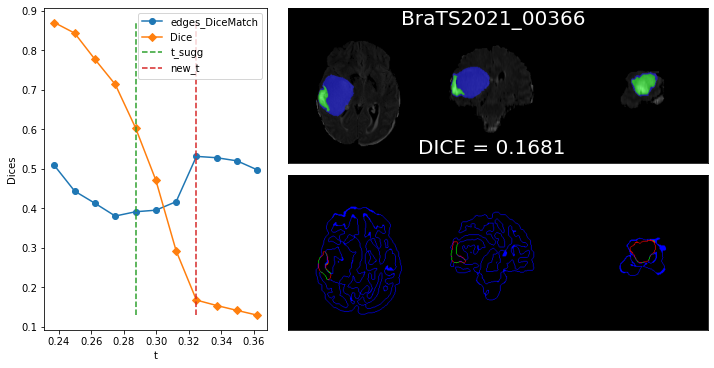

In [15]:
pos_sugg_t = sTDA.argmax_image(seg_union * img_flair_b)
new_seg = sE.plot_respectEdges(img_flair,seg_union_true,t,pos_sugg_t,brats_name=pb.brats_list[i],n_test=11,ovrlap=.05)

print('size difference :',new_seg.sum()/seg_union_true.sum(),seg_union_true.sum()/new_seg.sum())
print('')

The upper plot represents compares the suggested segmentation, with the one refined to the edges. If the new segmentation is better, one can execute the next cell to keep it as the segmentation $X$.

In [73]:
seg_union = new_seg

## Fill holes

In [5]:
seg_remaining = (seg_union>0)*1-1
seg_remaining[seg_remaining<0]=1
labels = skimage.measure.label(seg_remaining, background=0) #scipy.ndimage.label(seg_union_nocontour)
components = [(labels==i)*1 for i in range(1,np.max(labels))]

print('Number of remaining components:', len(components))

if len(components)>0:
    components_cardinal = [np.sum(component) for component in components]
    cardinalmax = max(components_cardinal)
    remainingcomponents = np.sum([components[i] for i in range(len(components)) if components_cardinal[i]<cardinalmax],0)
    seg_union[remainingcomponents>0] = 1

Number of remaining components: 28


## plot union segmentation

suggest_t : Compute curve... 

Computation of suggest_t done in  0:00:00s and 0.366cents  s
Dice 0.6249351001151268, DiceEdges = 0.3997282147103788
[0 1]


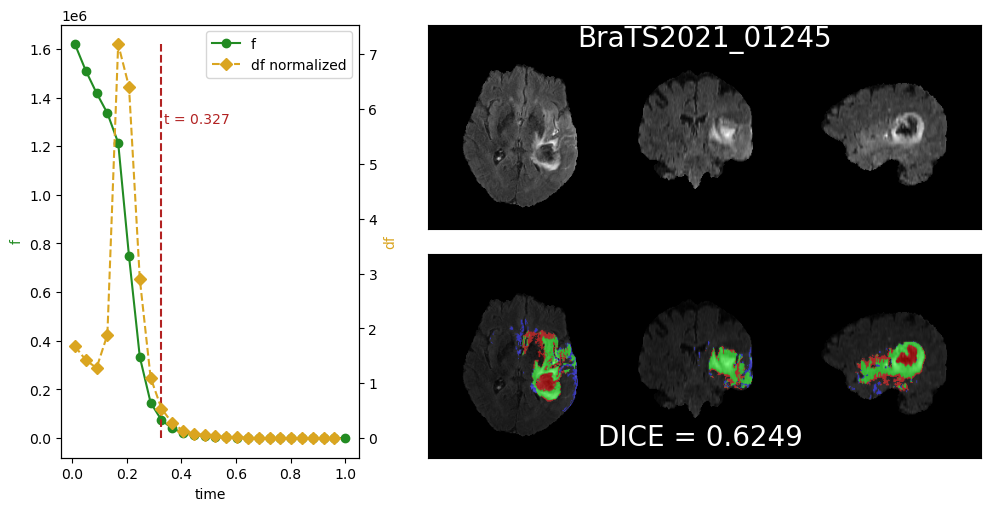

In [6]:
fig, axs = plt.subplots(2,2,
                            figsize = (10,5),
                            gridspec_kw={'width_ratios': [1, 2]},
                            constrained_layout=True)
gs = axs[0, 0].get_gridspec()
# remove the underlying axes
axs[0,0].remove()
axs[1,0].remove()
axbig = fig.add_subplot(gs[:, 0])

# 1st step: find segmentation union
# Find best t
_ = sTDA.suggest_t(img_flair_b, dt_threshold=1, verbose=True, plot=True,ax=axbig)

print(f"Dice {DICE(seg_union,seg_union_true)}, DiceEdges = {edges_DiceMatch(img_flair_b,seg_union)}")


axs[0,1].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
# axs[0,1].imshow(make_3d_flat(seg_true, pos),cmap='gray')
# plotMask(make_3d_flat(seg_union,pos),make_3d_flat(img_flair,pos),axs=axs[0,1], origin='upper')
axs[0,1].text(175,25,pb.brats_list[i],c='white',fontsize=20)
axs[1,1].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
axs[1,1].imshow(
    imCmp(
        make_3d_flat(seg_union_true, pos),
        make_3d_flat(seg_union, pos),
        method='seg'
    ),alpha=0.5
)
axs[1,1].text(200,225,f"DICE = {DICE(seg_union,seg_union_true):.4f}",c='white',fontsize=20)
set_ticks_off(axs[0,1])
set_ticks_off(axs[1,1])
print(np.unique(seg_union))
plt.show()

# Step 2 : ET Identification

In the previous step, we estimated the global segmentation $X \subset \Omega$, based on the image $I_\mathrm{FLAIR}$.
Note that, according to our model, we can decompose $X$ as $ X_\mathrm{ET}\cup X_\mathrm{TC}\cup X_\mathrm{WT}$, although we do not know the components at this point.
In this second step, we will use the image $I_\mathrm{T1ce}$, and the previously estimated segmentation $X$, to obtain $X_\mathrm{ET}$.

According to the model, the enhancing tumour $X_\mathrm{ET}$ is the boundary
of the tumour and is highly intense in the image. Hence, using a superlevel sets filtration, we should see in the $H_2$ persistence diagram a persistent cycle, representing the sphere formed by the boundary of the tumour.
More precisely, we compute the persistent homology of the superlevel sets filtration on the image $I_\mathrm{T1ce}$ restricted to $X$.

In order to automatise this procedure, we follow two steps:
- We compute the persistence diagram of the superlevel sets filtration of the image $I_\mathrm{T1ce}$ restricted to $X$, and identify the $H_2$-point of highest persistence.
- We extract the pixels that form this cycle as follows. Let $t_b$ be the birth value of this persistent cycle, and $x$ the corresponding pixel that gave birth to it. We then define $X_\mathrm{ET}$ as the connected component of the pixel $x$ in the binary image $I_\mathrm{T1ce}^{t_b}$.




There are 2027 bars.


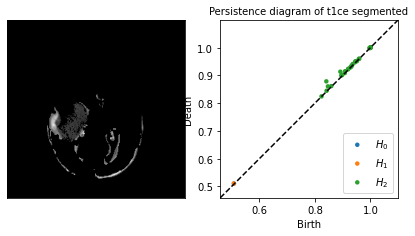

In [18]:
seg_union_t1ce = img_t1ce*seg_union
seg_union_t1ce_b = scipynd.gaussian_filter(seg_union_t1ce, sigma=1.5)  # <--- You can tune sigma here
# Compute persitence diagram
barcode = cripser.computePH(1-seg_union_t1ce_b,maxdim=3)
# Only non-infinite bars
H2 = [list(bar[1::]) for bar in barcode if bar[0]==2 and bar[2]<1]
 # Sort list H2 by persistence
H2 = [bar for _,bar in sorted(zip([bar[1]-bar[0] for bar in H2],H2))[::-1]]

print('There are '+repr(len(barcode))+' bars.')


# Plot diagram
if len(H2)>0:
    fig, ax = plt.subplots(1,2, figsize=(7,7))
    persim.plot_diagrams([np.array([barcode[0][1:3]]), np.array([barcode[0][1:3]]), np.array([bar[1:3] for bar in barcode if bar[0]==3-1])])
    ax[1].set_title('Persistence diagram of t1ce segmented',fontsize=10)
    
    # ax[0].imshow(img_t1ce[:,:,pos[2]].T,cmap='gray',alpha=.5)
    ax[0].imshow(seg_union_t1ce[:,:,pos[2]].T,cmap='gray',alpha=1)
    set_ticks_off(ax[0])
else:
    print('H2 is empty!')



In [ ]:
plt.imshow(seg)

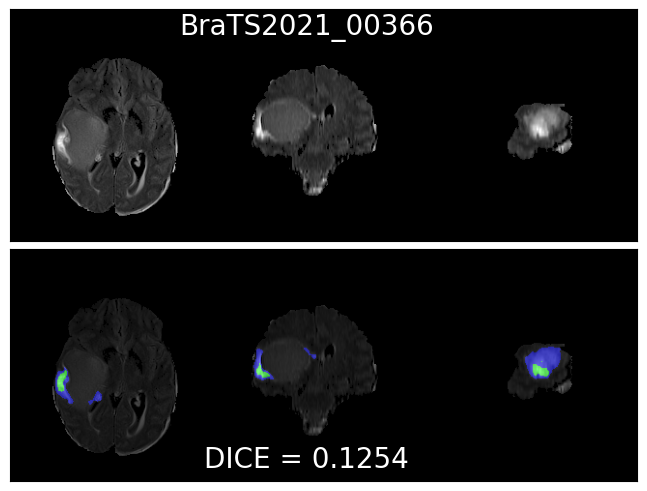

In [19]:
# Extract contour H2
i = 0
if len(H2)<=i:
    seg_contour = 0*seg_union_t1ce
else:
    bar = H2[i]
    pos_h2 = np.array(bar[2:5]).astype(int)
    t = bar[0]+0.0001
    seg_contour = sTDA.getConnectedComponent(seg_union_t1ce_b, pos, 1-t)

# ============== PLOT ==============

seg_contour_true = np.zeros(seg_true.shape)
seg_contour_true[seg_true == 4] = 1

fig,ax = plt.subplots(2,1,constrained_layout=True)
ax[0].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
ax[0].text(175,25,brats_name,c='white',fontsize=20)
ax[1].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
ax[1].imshow(
    imCmp(
        make_3d_flat(seg_contour_true, pos),
        make_3d_flat(seg_contour, pos),
        method='seg'
    ),alpha=0.5
)
ax[1].text(200,225,f"DICE = {DICE(seg_contour,seg_contour_true):.4f}",c='white',fontsize=20)
set_ticks_off(ax)
plt.show()

# Step 3: identification of TC and WT

At this point, we have estimated the segmentation of the global tumour, $X$, and the en-
hancing tumour $X_{\mathrm{ET}}$ . We now identify the components $X_{\mathrm{TC}}$ and $X_{\mathrm{WT}}$ . This step does not
depends on the initial MRI, but only on the subsets $X$ and $X_{\mathrm{ET}}$ .

Following our model, $\mathrm{TC}$ corresponds to the part of the tumour that lies inside $\mathrm{ET}$, and
$\mathrm{WT}$ to the part that lies outside $\mathrm{ET}$ (and still within $X$). In order to identify these parts,
we apply the following procedure.


Segmentation color code
    1. - ORANGE,   TC -> NECROSE INACTIVE, TUMORUS CORE
    2. - BLUE, WT -> INFILTRATION, OEDEME, WHOLE TUMOR
    4. - PURPLE,    ET -> NECROSE ACTIVE, ENHENCING TUMOR


In [5]:
seg_union_nocontour = seg_union - seg_contour
seg_nocontour_components = []
labels = skimage.measure.label(seg_union_nocontour, background=0)

N = 10 # select components with cardinal at least N
components = [(labels==i)*1 for i in range(1,np.max(labels))]
components = [component for component in components if np.sum(component)>N]
print('There are', len(components), 'components')

# Classify components: TC or WT
seg_final = seg_contour*4 # define seg_final
for component in components:
    component_dilated = binary_dilation(component, iterations=1)
    component_contour = component_dilated - component
    meanvalue = np.mean(seg_contour[np.where(component_contour > 0)])
    if meanvalue<1/2: #sort segmentation mask, label 2
        seg_final[component>0] = 2
    else: #label 1
        seg_final[component>0] = 1

# Fill the holes as they were TC
seg_remaining = (seg_final>0)*1-1
seg_remaining[seg_remaining<0]=1
labels = skimage.measure.label(seg_remaining, background=0)
components = [(labels==i)*1 for i in range(1,np.max(labels))]
print('Number of remaining components:', len(components))

if len(components)>0:
    components_cardinal = [np.sum(component) for component in components]
    cardinalmax = max(components_cardinal)
    remaining_components = np.sum(
        [
            components[i]
            for i in range(len(components))
            if components_cardinal[i]<cardinalmax
        ]
        ,0)
    seg_final[remaining_components>0] = 1


NameError: name 'seg_union' is not defined

In [4]:
# ============== PLOT ==============
from math import  prod

seg_contour_true = np.zeros(seg_true.shape)
seg_contour_true[seg_true == 4] = 1

fig,ax = plt.subplots(2,2,constrained_layout=True,figsize=(11,5))
ax[0,0].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
ax[0,0].text(175,25,brats_name,c='white',fontsize=20)

ax[1,0].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
ax[1,0].imshow(make_3d_flat(seg_true,pos),**DLT_KW_SEG)
ax[1,0].text(250,225,'True segmentation',c='white',fontsize=20)

ax[1,1].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
ax[1,1].imshow(make_3d_flat(seg_final,pos),**DLT_KW_SEG)
ax[1,1].text(250,225,'our segmentation',c='white',fontsize=20)

seg_superpose = np.zeros(seg_true.shape)
# Good segmentation => Green
good_bool = np.logical_and(
        (seg_true == seg_final),
        (seg_true + seg_final != 0)
    )
seg_superpose[good_bool] = 3
print(f"Well labeled pixels {good_bool.sum()}, proportion in image {good_bool.sum()/(seg_true>0).sum()}")

# It is part of the tumour but mislabeled => Orange
mislabeled_bool = np.logical_and(
        (seg_true != seg_final),
        (seg_true  >= 1),
        (seg_final >= 1)
     )
seg_superpose[mislabeled_bool]= 2
print(f"mislabeled pixels: {mislabeled_bool.sum()}")

# Not part of the tumour => Red
misseg_bool =  np.logical_and(
        (seg_true != seg_final),
        (seg_true  == 0)
     )
not_seg = np.logical_and(
    seg_true > 0,
    seg_final == 0
)
seg_superpose[np.logical_or(misseg_bool,not_seg)]= 1
print(f"Baddly segmented pixels {misseg_bool.sum()}")

cmap_cmp_segs = ListedColormap(
    [[0,0,0,0],
     '#D03A4E', # Rusty red
     '#E5BB60', # Gold
     '#13B644', # Dark pastel green
     ])
ax[0,1].imshow(make_3d_flat(img_flair,pos ),cmap='gray')
ax[0,1].imshow(make_3d_flat(seg_superpose,pos),cmap=cmap_cmp_segs,interpolation='nearest')

# ax[3].imshow(
#     imCmp(
#         make_3d_flat(seg_true, pos)/4,
#         make_3d_flat(seg_final, pos)/4,
#         method='seg'
#     ),alpha=0.5
# )
# ax[3].text(200,225,f"DICE = {DICE(seg_final,seg_true):.4f}",c='white',fontsize=20)
set_ticks_off(ax)
plt.show()

NameError: name 'seg_true' is not defined